<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/ChangHyun/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 환경 설정

#### 사전에 다운 받은 패키지 불러오기

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
#os.symlink('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/reference/my_env', my_path)
sys.path.insert(0, my_path)
os.chdir('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/notebook/ChangHyun/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### matplotlib 한글 깨짐 해결 코드

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,358 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155229 files and d

해당 [사이트](https://teddylee777.github.io/colab/colab-korean)를 참고하여 위의 코드를 실행한 다음 런타임 재시작을 해주어야 합니다.

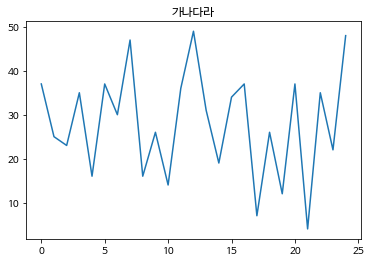

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 한글 지원 폰트
plt.rc('font', family='NanumBarunGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

plt.plot(np.random.randint(1, 50, 25))
plt.title("가나다라")
plt.show()

#### 앞으로 사용할 패키지 불러오기

In [3]:
import re
import time
from glob import glob
from tqdm import tqdm
from packages import utils, tokenizer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from collections import defaultdict, Counter

import tensorflow as tf
import sentencepiece as spm
from transformers import TFBertForSequenceClassification, BertTokenizer
from transformers import TextClassificationPipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## 데이터 불러오기

In [4]:
under_train = pd.read_csv("./sample_data.csv")
under_train.groupby("class").count().iloc[:,0]

class
0    896
1    896
2    896
3    896
4    896
Name: Unnamed: 0, dtype: int64

#### 훈련셋 검증셋 나누기

In [5]:
X = under_train["pre_conversation"].to_list()
Y = under_train["class"].to_list()

x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = 0.1, 
                                                            random_state = 200,
                                                            stratify = Y)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 202,
                                                stratify = y_val_test)
print(f"x_train 개수 : {len(x_train)}")
print(f"y_train 개수 : {len(y_train)}")
print(f"x_val 개수 : {len(x_val)}")
print(f"y_val 개수 : {len(y_val)}")
print(f"x_test 개수 : {len(x_test)}")
print(f"y_test 개수 : {len(y_test)}")

print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")

x_train 개수 : 4032
y_train 개수 : 4032
x_val 개수 : 224
y_val 개수 : 224
x_test 개수 : 224
y_test 개수 : 224
훈련 데이터 레이블 비율 확인 : Counter({3: 807, 4: 807, 1: 806, 0: 806, 2: 806})
검증 데이터 레이블 비율 확인 : Counter({0: 45, 2: 45, 3: 45, 1: 45, 4: 44})
테스트 데이터 레이블 비율 확인 : Counter({2: 45, 1: 45, 4: 45, 0: 45, 3: 44})


## HuggingFace 적용하기

#### Tokenizing

In [6]:
from transformers import ElectraTokenizer, TFElectraForSequenceClassification

HUGGINGFACE_MODEL_PATH = "monologg/koelectra-base-v3-discriminator"
# Load Tokenizer
tokenizer = ElectraTokenizer.from_pretrained(HUGGINGFACE_MODEL_PATH)

Downloading:   0%|          | 0.00/257k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467 [00:00<?, ?B/s]

In [7]:
# Tokenizing
train_encodings = tokenizer(x_train, truncation=True, padding=True)
val_encodings = tokenizer(x_val, truncation=True, padding=True)

for key in train_encodings:
  print(f"{key} : {train_encodings[key][0]}")

input_ids : [2, 6409, 9559, 10120, 4239, 3170, 4520, 3178, 6239, 4114, 4761, 7226, 6983, 4006, 4112, 6645, 3093, 4006, 4283, 4064, 4086, 10023, 3167, 4292, 2884, 7787, 4219, 3755, 23602, 7082, 4737, 4397, 3288, 4070, 7008, 3167, 4292, 3247, 4373, 7008, 8245, 4007, 4073, 4150, 6409, 4006, 4112, 6409, 4542, 4325, 26489, 4200, 2126, 14119, 4112, 6451, 4258, 4239, 2252, 2041, 4176, 3013, 7933, 10367, 4207, 4188, 4239, 9385, 2734, 4112, 3167, 4007, 4271, 2633, 4007, 4073, 4150, 3243, 4292, 8452, 4279, 4325, 7227, 4116, 23938, 2184, 7692, 4219, 3018, 4025, 27727, 9911, 4172, 3288, 4070, 6595, 11058, 4034, 3167, 4139, 4244, 6294, 4172, 2789, 4076, 4114, 4181, 3081, 4587, 10397, 3311, 4153, 7258, 24607, 3041, 4176, 2126, 3167, 6761, 2630, 4005, 20314, 4520, 6930, 4283, 4064, 8314, 4519, 11843, 7791, 4172, 4150, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Tensorflow dataset으로 변환

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), 
                                                    y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), 
                                                  y_val))
train_dataset

<TensorSliceDataset shapes: ({input_ids: (433,), token_type_ids: (433,), attention_mask: (433,)}, ()), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

#### Fine-tuning KoELECTRA

In [10]:
num_labels = max(under_train["class"]) + 1
model = TFElectraForSequenceClassification.from_pretrained(HUGGINGFACE_MODEL_PATH, 
                                                           num_labels=num_labels, 
                                                           from_pt=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, 
              loss=model.compute_loss, 
              metrics=['accuracy'])
model.summary()

Downloading:   0%|          | 0.00/431M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'electra.embeddings.position_ids', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing TFElectraForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFElectraForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dens

Model: "tf_electra_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 electra (TFElectraMainLayer  multiple                 112330752 
 )                                                               
                                                                 
 classifier (TFElectraClassi  multiple                 594437    
 ficationHead)                                                   
                                                                 
Total params: 112,925,189
Trainable params: 112,925,189
Non-trainable params: 0
_________________________________________________________________


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

callback_earlystop = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001, # the threshold that triggers the termination (acc should at least improve 0.001)
    patience=2)

model.fit(
    train_dataset.shuffle(1000).batch(16), epochs=1, batch_size=16,
    validation_data=val_dataset.shuffle(1000).batch(16),
    callbacks = [callback_earlystop]
)

252/252 [==============================] - 247s 904ms/step - loss: 0.7089 - accuracy: 0.7584 - val_loss: 0.5880 - val_accuracy: 0.8080


#### 모델 저장하기

In [ ]:
model_path = "./model/fine-tuned-koelectra-base-v3"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('./model/fine-tuned-klue-bert-base-2/tokenizer_config.json',
 './model/fine-tuned-klue-bert-base-2/special_tokens_map.json',
 './model/fine-tuned-klue-bert-base-2/vocab.txt',
 './model/fine-tuned-klue-bert-base-2/added_tokens.json')

## HuggingFace 모델 평가하기

In [13]:
# Load Fine-tuning model
#loaded_tokenizer = ElectraTokenizer.from_pretrained(model_path)
#loaded_model = TFElectraForSequenceClassification.from_pretrained(model_path)

text_classifier = TextClassificationPipeline(
    tokenizer=tokenizer, 
    model=model, 
    framework='tf',
    return_all_scores=True
)

In [14]:
predicted_label_list = []
predicted_score_list = []

for text in tqdm(x_test):
    # predict
    preds_list = text_classifier(text)[0]

    sorted_preds_list = max(preds_list, key=lambda x: x['score'])
    predicted_label_list.append(sorted_preds_list["label"]) # label
    predicted_score_list.append(sorted_preds_list["score"]) # score

100%|██████████| 224/224 [01:55<00:00,  1.93it/s]


In [15]:
y_pred = [int(label[-1]) for label in predicted_label_list]
y_true = y_test
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.31      0.47        45
           1       0.78      0.96      0.86        45
           2       1.00      0.98      0.99        45
           3       0.56      0.82      0.67        44
           4       0.93      0.96      0.95        45

    accuracy                           0.80       224
   macro avg       0.84      0.80      0.79       224
weighted avg       0.84      0.80      0.79       224



## 사후 평가

In [16]:
false_list = []
for i in range(len(y_true)):
  if y_true[i] != y_pred[i]:
    false_list.append(i)

In [17]:
test_dataset = pd.DataFrame({"x" : x_test, "y_true" : y_test, "y_pred" : y_pred})
test_dataset.iloc[false_list, :]

,x,y_true,y_pred
6,너 오랜만이다 그래 근데 오랜만이다 그런데 우리가 이럴 사이는 아니지 않냐 하 너 ...,0,3
8,앗 뜨거 뭐하시는거에요 그쪽 담뱃불에 데였잖아요 담배 들고만 있었는데 근처로 온 사...,0,3
12,야 쟤 잡아 넵 알겠습니다 제발 손가락은 자르지 말아주세요 야 미친 놈아 내가 정신...,0,3
14,벌써 며칠째야 어서 내가 말한 자료를 넘겨 말씀드렸던 대로 저도 접근 권한이 없습니...,0,4
17,운전똑바로해라 진짜 차로 받아버린다 서로조심합시다 뭘 서로 조심해 너가 조심해야지 ...,0,3
19,장기털리기 싫으면 내주차자리에 주차하지마 뭐 뭔개소리야이건 내가 여기 내주차자리라고...,0,3
24,너 뒤에서 내 욕하고 다녔다며 내가 언제 에게 얘기 다 들었어 가 잘못알았나보지 좋...,0,3
30,물건상태가 심한데 환불해주세요 무슨소리새요 저는 개봉도 안한 새상품을 판매한겁니다 ...,0,1
32,인스티지 너냐 응 왜 글내려라 생각이 있냐 너도 죽어 내가 왜 죽어 너나 죽어 야 ...,0,3
46,아 아줌마 어제 새벽에 왜 왔어요 아유 총각도 무슨 소리 하는거야 왜 왜 제 방에 ...,0,3


#### Confusion Matrix

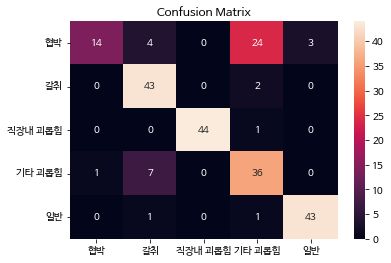

In [18]:
conf_matrix = confusion_matrix(y_true, y_pred)
names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘", "일반"]
conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
sns.heatmap(conf_matrix, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.show()

In [19]:
conf_matrix.style.background_gradient(cmap = "summer")

,협박,갈취,직장내 괴롭힘,기타 괴롭힘,일반
협박,14,4,0,24,3
갈취,0,43,0,2,0
직장내 괴롭힘,0,0,44,1,0
기타 괴롭힘,1,7,0,36,0
일반,0,1,0,1,43
